Zespoły klasyfikatorów
----

In [ ]:
!git clone https://github.com/matzim95/ML-datasets


Cloning into 'ML-datasets'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 194 (delta 33), reused 124 (delta 24), pack-reused 60
Receiving objects: 100% (194/194), 35.45 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (127/127), done.


In [ ]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ML-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'breast_cancer' : {'class_column' : 'Class', 'index_col': 'Sample code number'}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [ ]:
X, y, classes = prepare_dataset('wine')

In [ ]:
load_dataset('breast_cancer', 'Class')

(     Sample code number  Clump Thickness  Uniformity of Cell Size  \
 0               1000025                5                        1   
 1               1002945                5                        4   
 2               1015425                3                        1   
 3               1016277                6                        8   
 4               1017023                4                        1   
 ..                  ...              ...                      ...   
 694              776715                3                        1   
 695              841769                2                        1   
 696              888820                5                       10   
 697              897471                4                        8   
 698              897471                4                        8   
 
      Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
 0                           1                  1                           

In [ ]:
classes

array(['one', 'two', 'three'], dtype=object)

Bagging
---

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer, StandardScaler


In [ ]:
normalizer = Normalizer()
standarizer = StandardScaler()
preprocessor = standarizer

## Testy na zbiorach danych

In [ ]:

def preprocess_data(X, preprocessor=None):
    if preprocessor is not None:
        preprocessor.fit(X)
        X_preprocessed = X.copy()
        X_preprocessed[:] = preprocessor.transform(X.values)
        X = X_preprocessed
    return X

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')
    
def plot_confusion_matrix(confusion_matrix, classes, title=None,
                          title_appendix='',
                          cmap=plt.cm.Blues):
    # tytuł wykresu
    if title_appendix:
        title_appendix = f'({title_appendix})'
    if title is None:
        title = f'Confusion matrix {title_appendix}'
    
    fig, ax = plt.subplots()
    # rysuje CM (confusion matrix)
    img = ax.imshow(confusion_matrix, cmap=cmap)
    # dodaje pasek z boku
    ax.figure.colorbar(img, ax=ax)
    # dodatki do wykresu
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_xticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticklabels(classes, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
    # etykiety
    fmt = '.2f' if confusion_matrix.dtype == 'float' else 'd'
    thresh = confusion_matrix.max() / 2
    for y, row in enumerate(confusion_matrix):
        for x, cell in enumerate(row):
            ax.text(x, y, format(cell, fmt),
                    ha='center', va='center',
                    color='white' if cell > thresh else 'black')
    fig.tight_layout()
    
    return ax

def normalize_confusion_matrix(confusion_matrix):
    return confusion_matrix.astype(
        'float') / confusion_matrix.sum(
        axis=1)[np.newaxis].T

In [ ]:
X, y, classes = prepare_dataset('wine')
X = preprocess_data(X, standarizer)
X.describe()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.619821e-16,-8.357859e-17,-8.657245e-16,-1.160121e-16,-1.995907e-17,-2.972030e-16,-4.016762e-16,4.079134e-16,-1.699639e-16,-1.122697e-17,3.717376e-16,2.919013e-16,-7.484650e-18
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246e+00,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-8.854682e-01,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,9.595986e-02,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,8.089974e-01,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515e+00,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [ ]:

print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

2    71
0    59
1    48
Name: class, dtype: int64
2    57
0    47
1    38
Name: class, dtype: int64
2    14
0    12
1    10
Name: class, dtype: int64


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.9166666666666666
  Precision: 0.923076923076923
  Recall:    0.9246031746031745
  F1 score:  0.9229629629629629
  Mislabeled 3 out of 36




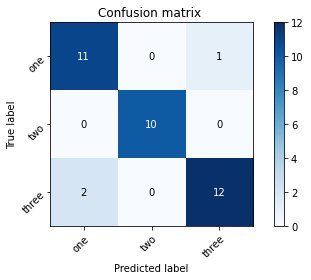

In [ ]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

In [ ]:
bclf = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 50)
bclf.fit(X_train, y_train)
y_b = bclf.predict(X_test)

Results for Bagging Ensemble
----
  Accuracy:  1.0
  Precision: 1.0
  Recall:    1.0
  F1 score:  1.0
  Mislabeled 0 out of 36




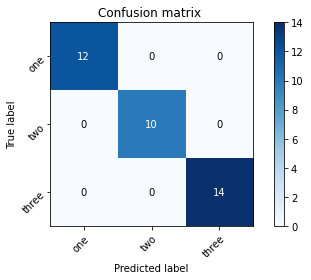

In [ ]:
print_results(calculate_metrics(y_test.values, y_b), 'Bagging Ensemble')
cm = confusion_matrix(y_test, y_b)
plot_confusion_matrix(cm, classes)

In [ ]:
print(bclf.estimators_)

[DecisionTreeClassifier(random_state=1310936384), DecisionTreeClassifier(random_state=1627436704), DecisionTreeClassifier(random_state=945851881), DecisionTreeClassifier(random_state=1629838396), DecisionTreeClassifier(random_state=1011601881), DecisionTreeClassifier(random_state=1974240173), DecisionTreeClassifier(random_state=1742062725), DecisionTreeClassifier(random_state=1530222349), DecisionTreeClassifier(random_state=550817163), DecisionTreeClassifier(random_state=1094138282), DecisionTreeClassifier(random_state=620328213), DecisionTreeClassifier(random_state=744969641), DecisionTreeClassifier(random_state=692038845), DecisionTreeClassifier(random_state=77716833), DecisionTreeClassifier(random_state=1051212866), DecisionTreeClassifier(random_state=966076207), DecisionTreeClassifier(random_state=1675939944), DecisionTreeClassifier(random_state=1757748302), DecisionTreeClassifier(random_state=743285917), DecisionTreeClassifier(random_state=658771311), DecisionTreeClassifier(random

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def cross_validate1(classifier, kfold, X, y, classes, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        plot_confusion_matrix(normalize_confusion_matrix(cm),
                              classes,
                              title_appendix=clf.__class__.__name__)
        plt.show()
    else:
        return metrics, cm

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(bclf, X, y, cv=10)
cv_results_tree = cross_validate(tree, X, y, cv=10)

In [ ]:
print(cv_results['test_score'])
print(cv_results_tree['test_score'])

[0.94444444 1.         0.83333333 0.94444444 0.88888889 0.94444444
 1.         0.94444444 1.         1.        ]
[0.88888889 0.88888889 0.72222222 0.88888889 0.83333333 0.83333333
 1.         0.88888889 0.94117647 0.70588235]


Results for DecisionTreeClassifier
----
  Accuracy:  0.8651685393258427
  Precision: 0.8676064123825319
  Recall:    0.8655075462189332
  F1 score:  0.8650958391771857
  Mislabeled 24 out of 178




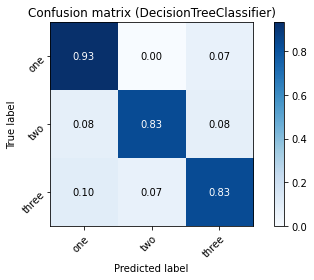

In [ ]:
cross_validate1(DecisionTreeClassifier, StratifiedKFold(10), X, y, classes)

Results for BaggingClassifier
----
  Accuracy:  0.949438202247191
  Precision: 0.9485385878489326
  Recall:    0.9513374976791066
  F1 score:  0.9497682324430045
  Mislabeled 9 out of 178




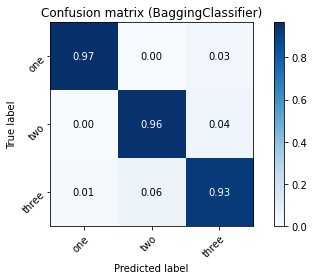

In [ ]:
cross_validate1(BaggingClassifier, StratifiedKFold(10), X, y, classes)

Zad.1. Zapoznaj się z kodem i colabem oraz sprobuj wykonac klasyfikacje na zbiorze breast_cancer.csv. Zakoduj lub usun znak zapytania w kolumnie bare_nuclei.
Wypróuj 2 znane  CI pojedyncze klasyfikatory oraz BaggingClassifier. Jako rezultat wyświetl f1_score dla wszystkich algorytmów.

Rozwiązanie


In [ ]:
X, y, classes = prepare_dataset('breast_cancer')

In [ ]:
X['Bare Nuclei'] = X['Bare Nuclei'].replace('?', value=1)


In [ ]:
X = preprocess_data(X, standarizer)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X.describe()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
count,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02,6.990000e+02
mean,1.655011e-16,-2.801765e-16,-5.854481e-16,-1.477121e-16,-1.021199e-15,7.026648e-16,6.251556e-16,3.874662e-16,7.093356e-16
std,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00,1.000716e+00
min,-1.214667e+00,-6.999951e-01,-7.432990e-01,-6.332472e-01,-1.001495e+00,-6.869792e-01,-1.000471e+00,-6.118250e-01,-3.439118e-01
25%,-8.592662e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-6.869792e-01,-5.900668e-01,-6.118250e-01,-3.439118e-01
50%,-1.484649e-01,-6.999951e-01,-7.432990e-01,-6.332472e-01,-5.495614e-01,-6.869792e-01,-1.796621e-01,-6.118250e-01,-3.439118e-01
75%,5.623364e-01,6.117919e-01,6.035993e-01,4.181537e-01,3.543054e-01,4.181956e-01,6.411472e-01,3.713145e-01,-3.439118e-01
max,1.983939e+00,2.251526e+00,2.287222e+00,2.520955e+00,3.065906e+00,1.799664e+00,2.693171e+00,2.337594e+00,4.907421e+00


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

1 Klasyfikator

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

Results for Decision Tree
----
  Accuracy:  0.9142857142857143
  Precision: 0.9128787878787878
  Recall:    0.894927536231884
  F1 score:  0.9028677150786308
  Mislabeled 12 out of 140




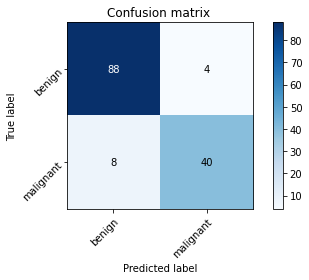

In [ ]:
print_results(calculate_metrics(y_test.values, y_tree), 'Decision Tree')
cm = confusion_matrix(y_test, y_tree)
plot_confusion_matrix(cm, classes)

2 Klasyfikator

In [ ]:
bclf = BaggingClassifier(base_estimator = SVC())
bclf.fit(X_train, y_train)
y_bclf = bclf.predict(X_test)

Results for BaggingClassifier
----
  Accuracy:  0.9642857142857143
  Precision: 0.9583987441130298
  Recall:    0.9628623188405797
  F1 score:  0.960565601937919
  Mislabeled 5 out of 140




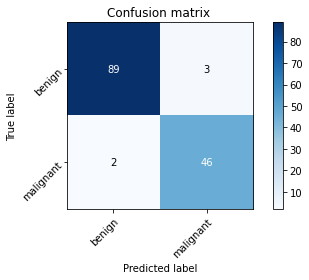

In [ ]:
print_results(calculate_metrics(y_test.values, y_bclf), 'BaggingClassifier')
cm = confusion_matrix(y_test, y_bclf)
plot_confusion_matrix(cm, classes)

Random Forest
----

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()

rfclf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_rf = rfclf.predict(X_test)

In [ ]:
print(rfclf.estimators_)

[DecisionTreeClassifier(max_features='auto', random_state=2000204740), DecisionTreeClassifier(max_features='auto', random_state=1725564219), DecisionTreeClassifier(max_features='auto', random_state=590447677), DecisionTreeClassifier(max_features='auto', random_state=1979923743), DecisionTreeClassifier(max_features='auto', random_state=1636957367), DecisionTreeClassifier(max_features='auto', random_state=20249594), DecisionTreeClassifier(max_features='auto', random_state=1715168238), DecisionTreeClassifier(max_features='auto', random_state=252913958), DecisionTreeClassifier(max_features='auto', random_state=57991686), DecisionTreeClassifier(max_features='auto', random_state=640126025), DecisionTreeClassifier(max_features='auto', random_state=1800731395), DecisionTreeClassifier(max_features='auto', random_state=746767173), DecisionTreeClassifier(max_features='auto', random_state=918420758), DecisionTreeClassifier(max_features='auto', random_state=1301689297), DecisionTreeClassifier(max_f

Results for RF Ensemble
----
  Accuracy:  0.95
  Precision: 0.9465797300388927
  Recall:    0.9420289855072463
  F1 score:  0.9442389758179233
  Mislabeled 7 out of 140




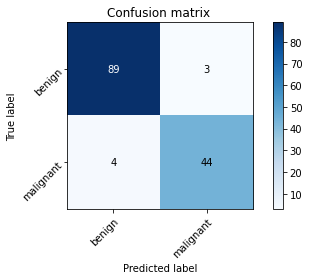

In [ ]:
print_results(calculate_metrics(y_test.values, y_rf), 'RF Ensemble')
cm = confusion_matrix(y_test, y_rf)
plot_confusion_matrix(cm, classes)

Results for RandomForestClassifier
----
  Accuracy:  0.9670958512160229
  Precision: 0.9623716447486939
  Recall:    0.9650609722952037
  F1 score:  0.9636928218967719
  Mislabeled 23 out of 699




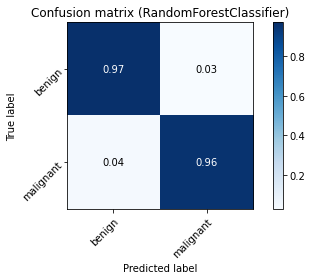

In [ ]:
cross_validate1(RandomForestClassifier, StratifiedKFold(10), X, y, classes)

In [ ]:
cross_validate_rf = cross_validate(rfclf, X, y, cv=10)
np.mean(cross_validate_rf['test_score'])

0.9671221532091099

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_rf)

0.9263157894736843

Zad.2. Wykonaj random forest na tym samym zbiorze danych co w zadaniu 1 (breast_cancer.csv) i zwróc uwagę na liczbe estimatorów i parametry typowo drzewiaste (min_samples_split, min_samples_leaf, max_depth, criterion) - sprobuj wybrac mozliwie najlepsze. Jako rezultat zapisz f1_score na zb testowym oraz sredni wynik z testowych score crooss walidacji (np.mean(cross_validate_rf['test_score']))

Ada Boost Classifier


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abclf = AdaBoostClassifier(base_estimator = SVC(), n_estimators = 50, algorithm = 'SAMME')#trzeba zmienic algorithm na SAMME jezeli chcemy inny base_estimator niż drzewo
abclf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=SVC())

In [ ]:
y_ab = abclf.predict(X_test)

Results for AdaBoost Ensemble
----
  Accuracy:  0.6571428571428571
  Precision: 0.32857142857142857
  Recall:    0.5
  F1 score:  0.39655172413793105
  Mislabeled 48 out of 140




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


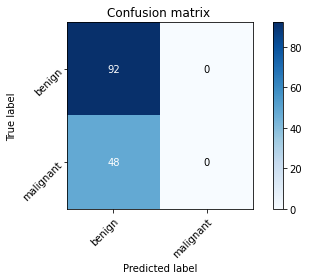

In [ ]:
print_results(calculate_metrics(y_test.values, y_ab), 'AdaBoost Ensemble')
cm = confusion_matrix(y_test, y_ab)
plot_confusion_matrix(cm, classes)

In [ ]:
#cross_validate(abclf, StratifiedKFold(10), X, y, classes)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
cv_results = cross_validate(abclf, X,y, cv=10)

In [ ]:
np.mean(cv_results['test_score'])

0.6552173913043479

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbclf = GradientBoostingClassifier( n_estimators = 50)
gbclf.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=50)

In [ ]:
y_gb = gbclf.predict(X_test)

Results for GradientBoosting Ensemble
----
  Accuracy:  0.9428571428571428
  Precision: 0.9365942028985508
  Recall:    0.9365942028985508
  F1 score:  0.9365942028985508
  Mislabeled 8 out of 140




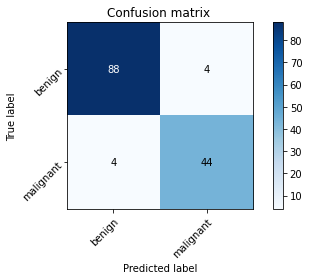

In [ ]:
print_results(calculate_metrics(y_test.values, y_gb), 'GradientBoosting Ensemble')
cm = confusion_matrix(y_test, y_gb)
plot_confusion_matrix(cm, classes)

In [ ]:
cv_results = cross_validate(gbclf, X,y, cv=10)

In [ ]:
cv_results['test_score']

array([0.88571429, 0.94285714, 0.97142857, 0.91428571, 0.97142857,
       0.95714286, 0.97142857, 0.98571429, 0.98571429, 0.98550725])

Zad.3. Uzyj zbioru glass i wykonaj na nim uczenie wszystkimi poznanymi (gradient boosting, ada boost, random forest) dziś algorytmami, poustawiaj parametry dla tych algorytmów jak również dla estymatorów bazowych np. SVM(C=10, gamma=0.001), tak aby osiągnąc możliwe najlepszy f1_score, mean(cv_test_score). Zapisz wyniki dla najlepszego.

In [ ]:
X, y, classes = prepare_dataset('glass')

In [ ]:
X = preprocess_data(X, standarizer)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()

rfclf.fit(X_train, y_train)
y_rfclf = rfclf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for RF Ensemble
----
  Accuracy:  0.7441860465116279
  Precision: 0.6599511599511599
  Recall:    0.6984126984126983
  F1 score:  0.6645604395604395
  Mislabeled 11 out of 43




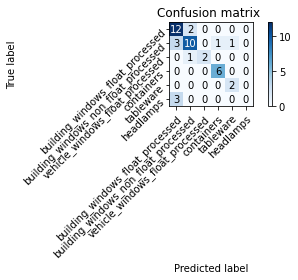

In [ ]:
print_results(calculate_metrics(y_test.values, y_rfclf), 'RF Ensemble')
cm = confusion_matrix(y_test, y_rfclf)
plot_confusion_matrix(cm, classes)

In [ ]:
results_rf = cross_validate(rfclf, X, y, cv=9)

In [ ]:
results_rf['test_score']

array([0.70833333, 0.75      , 0.79166667, 0.70833333, 0.70833333,
       0.91666667, 0.58333333, 0.7826087 , 0.82608696])

Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
bgclf = GradientBoostingClassifier(n_estimators = 15)

gbclf.fit(X_train, y_train)
y_gbclf = gbclf.predict(X_test)

Results for RF Ensemble
----
  Accuracy:  0.8372093023255814
  Precision: 0.7886904761904763
  Recall:    0.83015873015873
  F1 score:  0.799255583126551
  Mislabeled 7 out of 43




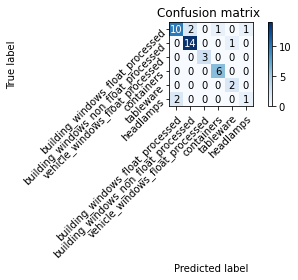

In [ ]:
print_results(calculate_metrics(y_test.values, y_gbclf), 'RF Ensemble')
cm = confusion_matrix(y_test, y_gbclf)
plot_confusion_matrix(cm, classes)

In [ ]:
results_gbclf = cross_validate(GradientBoostingClassifier(), X, y, cv=5)
results_gbclf['test_score']

array([0.69767442, 0.74418605, 0.60465116, 0.58139535, 0.69047619])

In [ ]:
import xgboost as xgb 
from sklearn.metrics import roc_auc_score
# świadomie chcę mieć dwa niezależne zbiory walidacyjne. Przyda mi się na przyszłość jak będę robił optymalizację hiperparametrów
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2019)

print('TRAIN:',X_train.shape, y_train.shape)
print('TEST:',X_test.shape, y_test.shape)
print('VALIDATION:',X_val.shape, y_val.shape)

TRAIN: (171, 9) (171,)
TEST: (21, 9) (21,)
VALIDATION: (22, 9) (22,)


In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)  
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict

print("\auc_for_xgb")
# assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
roc_auc_multiclass = roc_auc_score_multiclass(y_test, y_pred)
print(roc_auc_multiclass)


uc_for_xgb
{0: 0.8375, 1: 0.9027777777777777, 2: 0.9500000000000001, 3: 0.8333333333333333, 4: 1.0, 5: 0.5}
\gini_for_xgb


In [ ]:
for i in range(len(roc_auc_multiclass)):
  print(2*roc_auc_multiclass[i] - 1)


0.675
0.8055555555555554
0.9000000000000001
0.6666666666666665
1.0
0.0
